In [ ]:
! pip install finlab > log.txt
! wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download > log.txt

--2023-01-05 14:13:18--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.161.138, 142.251.161.113, 142.251.161.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.161.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/of3g1a8o0qn6rj0jeq6q35u2nq9kgs3d/1672927950000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=699107ed-25bb-48b0-b4d2-c6a671cbbf9e [following]
--2023-01-05 14:13:22--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/of3g1a8o0qn6rj0jeq6q35u2nq9kgs3d/1672927950000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=699107ed-25bb-48b0-b4d2-c6a671cbbf9e
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.192.132, 2607:f8b0:4001:c0e::84
Connecting to d

In [ ]:
import finlab
from finlab import backtest
from finlab import data
import pandas as pd
import scipy.stats as stats
import numpy as np
import warnings
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

warnings.filterwarnings('ignore')

# plt.style.use('seaborn')  
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# 上市+上櫃
with data.universe(market='TSE_OTC',category='金融'):
    financialColumns =data.get('price:收盤價').columns
with data.universe(market='TSE_OTC'):
    allColumns =data.get('price:收盤價').columns

# 上市 (ETF母體)
with data.universe(market='TSE',category='金融'):
    financialTseColumns =data.get('price:收盤價').columns
with data.universe(market='TSE'):
    allTseColumns =data.get('price:收盤價').columns


# 上櫃
with data.universe(market='OTC',category='金融'):
    financialOtcColumns =data.get('price:收盤價').columns
with data.universe(market='OTC'):
    allOtcColumns =data.get('price:收盤價').columns

data.set_universe(market='TSE_OTC')

輸入成功!


In [ ]:
# 標準化(z-score) , mean=0 std=1
def Z(df):
    df= df.apply(stats.zscore,axis=1,nan_policy='omit') # zscore, 忽略nan
    cond = (df>3) | (df<-3) # 只留下3個std以內的資料,離群值不採納
    df[cond] = np.nan
    return df

# 取得變數名稱
def getVarName(var):
    varName = [name for name in globals() if globals()[name] is var][0] #時好時壞，不太確定為啥
    return varName


def diffList(a,b): #在A裡面不在B裡面的元素
    return [i for i in a if i not in b]

# 模擬 smart 單因子選股條件回測

## 價值因子

In [ ]:
# 取得股票資料
收盤價 = data.get("price:收盤價")
營業現金流量 = data.get('financial_statement:營業活動之淨現金流入_流出')
股本 = data.get('financial_statement:股本')
每股營業現金流量 = 營業現金流量 / (股本/10)

稅前息前折舊前淨利率 = data.get('fundamental_features:稅前息前折舊前淨利率')
營業收入淨額 = data.get("financial_statement:營業收入淨額")
EBITDA = 稅前息前折舊前淨利率*營業收入淨額/100
負債總額 = data.get('financial_statement:負債總額') 
現金及約當現金 = data.get('financial_statement:期末現金及約當現金餘額')
市值 = 股本/10*收盤價
企業價值 = 市值 + 負債總額 - 現金及約當現金


每股盈餘 = data.get('financial_statement:每股盈餘')

股息殖利率 = data.get('price_earning_ratio:殖利率(%)')
發行股數 = data.get('internal_equity_changes:發行股數') #改股本
前一年發行股數 = data.get('internal_equity_changes:發行股數').shift(12)  # 一年12個月
庫藏股回購率 = (發行股數 - 前一年發行股數) * (收盤價 / 市值)


# 計算價值因子指標
營業現金流量對股價比 = 每股營業現金流量 / 收盤價
EBITDA對企業價值比 = EBITDA /企業價值
益本比 = 每股盈餘 / 收盤價
股東收益率 = 股息殖利率 + 庫藏股回購率

# 計算價值因子分數

價值因子分數 = 0.4 * Z(營業現金流量對股價比) + 0.4* Z(益本比) + 0.2 * Z(股東收益率) #用非金融股算法計算全部
價值因子分數_金融 = 0.3 * Z(營業現金流量對股價比) +0.3 * Z(EBITDA對企業價值比) + 0.3 * Z(益本比) + 0.1 * Z(股東收益率) #用金融股算法計算全部
finCol = 價值因子分數_金融.columns.intersection(financialColumns) # 取交集過濾掉已經下市的股票
價值因子分數[finCol] = 價值因子分數_金融[finCol] # 再用金融股的值代入金融股的值
# 至此已得所有TSE & OTC 股票的價值因子分數

## 品質因子

In [ ]:
負債總額 = data.get('financial_statement:負債總額') 
資產總額 = data.get('financial_statement:資產總額') 
普通股股本 = data.get('financial_statement:普通股股本') 
每股淨值= (資產總額-負債總額)/ (普通股股本/10)
每股盈餘 = data.get('financial_statement:每股盈餘')
股東權益報酬率 = 每股盈餘 / 每股淨值


#收益變動率 晚點回來補 #從2019 Q2才有值，之後可能要做一些更正
每股盈餘=data.get('financial_statement:每股盈餘')
近一年每股盈餘 = 每股盈餘.rolling(4).sum()
前一年每股盈餘 = 近一年每股盈餘.shift(4)
盈餘成長率 = 100*(近一年每股盈餘/前一年每股盈餘 - 1)
收益變動率 = -1 * 盈餘成長率.rolling(12).std() #近五年的盈餘成長率標準差 => 縮短成近三年(資料筆數太少)


營業現金流量 = data.get('financial_statement:營業活動之淨現金流入_流出')
現金流量對資產比 = 營業現金流量 / 資產總額


資產報酬率 = data.get('fundamental_features:ROA稅後息前')


營業毛利 = data.get('financial_statement:營業毛利') 
毛利對資產比 = 營業毛利 / 資產總額


市值 = 股本/10*收盤價
長期負債總額 = data.get('financial_statement:非流動負債').fillna(0)
特別股股本 = data.get('financial_statement:特別股股本').fillna(0)
市場槓桿= (市值 + 長期負債總額 + 特別股股本) / 市值
權益總額 = data.get('financial_statement:股東權益總額') 
帳面價值槓桿=(權益總額 + 長期負債總額 + 特別股股本) / 權益總額
負債比率 = data.get('fundamental_features:負債比率') 
槓桿度 = (市場槓桿 + 帳面價值槓桿 + 負債比率)/3 * -1

品質因子分數 = 1/3 * (Z(股東權益報酬率) + Z(收益變動率) + Z(資產報酬率))#用非金融股算法計算全部
allCol = 品質因子分數.columns.intersection(allColumns)
品質因子分數 = 品質因子分數[allCol]
finCol = 品質因子分數.columns.intersection(financialColumns)
品質因子分數[financialColumns] = 0

品質因子分數_金融 =0.2 *( Z(股東權益報酬率) +  Z(收益變動率) +  Z(現金流量對資產比) +  Z(毛利對資產比)+Z(槓桿度)) #用金融股算法計算全部
品質因子分數_金融 = 品質因子分數_金融[allCol]
notFinCol = diffList(allCol,financialColumns)
品質因子分數_金融[notFinCol] = 0
品質因子分數 = 品質因子分數 + 品質因子分數_金融

## 動能因子

In [ ]:
還原收盤價 = data.get('etl:adj_close') 
月底還原收盤價 = 還原收盤價.resample('M').last() #每月最後一天的收盤價
前1_月底還原收盤價 = 月底還原收盤價.shift(1) 
前7_月底還原收盤價 = 月底還原收盤價.shift(7) 
前13_月底還原收盤價 = 月底還原收盤價.shift(13) 
隔夜拆款利率 = 0.08*0.01 #無日資料，暫以常數估算
周還原收盤價 = 還原收盤價.resample('W').last().pct_change() #每周最後一天的收盤價計算"報酬率"之標準差
近三年週標準差 = 周還原收盤價.ffill().rolling(52*3).std()
年化標準差 = 近三年週標準差.apply(lambda x:pow(10,1/3**0.5*np.log10(1+x))-1) #轉為年化標準差 #參考https://junhaoshihmd.blogspot.com/2017/01/monthly-annualized-return-std-conversion.html
股價動能 = 0.5*((前1_月底還原收盤價/前7_月底還原收盤價-1-隔夜拆款利率) + (前1_月底還原收盤價/前13_月底還原收盤價-1-隔夜拆款利率))/年化標準差


營利動能 = (每股盈餘 - 每股盈餘.shift()) / 收盤價


# 計算動能因子分數
動能因子分數 = 1/2 * (Z(股價動能) + Z(營利動能))

## 多因子分數 => 多因子權重係數

In [ ]:
#計算多因子權重
多因子分數 = 0.4 * 品質因子分數 + 0.3 * 價值因子分數 + 0.3 * 動能因子分數
多因子權重係數 = 多因子分數.applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
多因子權重係數.dropna(axis=0,how='all',inplace=True)
startDate = 多因子權重係數.index[0]

## 回測

In [ ]:
# 選取多因子權重係數大於等於75分位數者為成分股

#training
col = 多因子權重係數.columns.intersection(allTseColumns)
多因子權重係數_TSE = 多因子權重係數[col]
cond = 多因子權重係數_TSE < 多因子權重係數_TSE.quantile_row(0.75) #計算多因子權重係數小於75分位數的股票
多因子權重係數_TSE[cond] = 0 # 設權重為0
position = 多因子權重係數_TSE.index_str_to_date().loc[startDate:"2020-08-10"]
report = backtest.sim(position,fee_ratio=0,tax_ratio=0)

In [ ]:
#testing
position = 多因子權重係數_TSE.index_str_to_date().loc["2020-08-10":] 
report = backtest.sim(position,fee_ratio=0,tax_ratio=0)

# 單因子報酬率回測

## 價值、品質、動能單因子回測(報酬率)

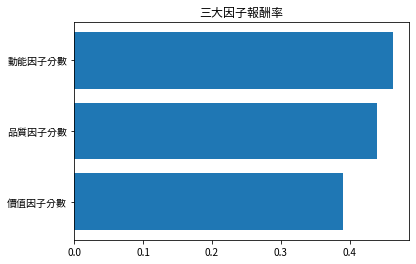

In [ ]:
creturnPolyDf = pd.DataFrame()

for score in [價值因子分數,品質因子分數,動能因子分數]:
    scoreName = getVarName(score)
    col = score.columns.intersection(allTseColumns)
    score = score[col]
    scoreWeight = score.applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
    cond = scoreWeight <= scoreWeight.quantile_row(0.75)
    scoreWeight[cond] = 0
    position = scoreWeight.index_str_to_date().loc[startDate:"2020-08-10"]
    report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
    report.benchmark = data.get('benchmark_return:發行量加權股價報酬指數').squeeze()
    creturnPolyDf[scoreName] = [report.creturn[-1]]
    # print(getVarName(score))
    # report.display()


#按照總報酬率作圖
creturnPolyDf = creturnPolyDf.T.sort_values(0) - 1
creturnPolyDf.columns=["creturn"]
plt.barh(creturnPolyDf.index,creturnPolyDf["creturn"])
plt.yticks(np.arange(0,3),creturnPolyDf.index)
plt.title("三大因子報酬率")
plt.show()

## 細項單因子回測(報酬率)

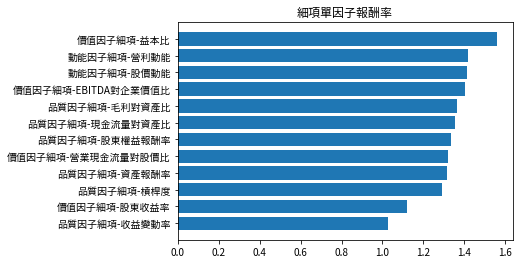

In [ ]:
價值因子細項 = [營業現金流量對股價比,EBITDA對企業價值比,益本比,股東收益率]
品質因子細項 = [股東權益報酬率,收益變動率,現金流量對資產比,資產報酬率,毛利對資產比,槓桿度]
動能因子細項 = [股價動能,營利動能]
creturnDf = pd.DataFrame()

for category in [價值因子細項,品質因子細項,動能因子細項]:
    for feature in category:
        categoryName = getVarName(category)
        featureName = getVarName(feature)
        feature = Z(feature)
        col = feature.columns.intersection(allTseColumns)
        feature = feature[col]
        scoreWeight = feature.applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
        cond = scoreWeight <= scoreWeight.quantile_row(0.75)
        scoreWeight[cond] = 0
        position = scoreWeight.index_str_to_date().loc[startDate:"2020-08-10"]
        report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
        creturnDf[f'{categoryName}-{featureName}'] = [report.creturn[-1]]      

# 做報酬率排名圖
creturnDf = creturnDf.T.sort_values(0) #預設column name為0
creturnDf.columns=["creturn"]
plt.barh(creturnDf.index,creturnDf["creturn"])
plt.yticks(np.arange(0,12),creturnDf.index)
plt.title("細項單因子報酬率")
plt.show()

# 單因子線性回歸，相關性排序

## 函式定義

In [ ]:
def findSlopeConst(x,y): #找到斜率&常數
    A = np.vstack([x,np.ones(len(x))]).T
    m,c = np.linalg.lstsq(A,y,rcond=None)[0]
    return m,c

def plotLine(x,y,m,c,title,axisInterval=[0, 1, 0, 4],subplots=plt): #畫出模擬直線
    subplots.plot(x,y,'o',label='Original data', markersize=8) #畫點
    subplots.plot(x,m*x+c,label='Fitted line') #畫線
    subplots.legend(loc='upper left') #顯示圖例(label)
    subplots.axis(axisInterval) # plt.axis([xmin, xmax, ymin, ymax])
    if (subplots == plt):
        plt.title(title)
        plt.show()
    else:
        subplots.set_title(title)

## 價值、品質、動能單因子回測(相關性)

In [ ]:
# 按照百分位數切成5等分，回測每等分的報酬率
corrPolyDf = pd.DataFrame()

for score in [價值因子分數,品質因子分數,動能因子分數]:
    corrList=[]
    scoreName = getVarName(score)
    col = score.columns.intersection(allTseColumns)
    score = score[col]
    for interval in range(0,100,20):
        scoreWeight = score.applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
        cond = (scoreWeight >= scoreWeight.quantile_row(interval/100)) & (scoreWeight <= scoreWeight.quantile_row(interval/100+0.2))
        scoreWeight[~cond] = 0
        position = scoreWeight.index_str_to_date().loc[startDate:"2020-08-10"]
        report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
        report.benchmark = data.get('benchmark_return:發行量加權股價報酬指數').squeeze()
        corrList.append(report.creturn[-1])
    corrPolyDf[scoreName] = corrList
corrPolyDf.index = ["0-20","20-40","40-60","60-80","80-100"]
corrPolyDf = corrPolyDf.T
corrPolyDf

,0-20,20-40,40-60,60-80,80-100
價值因子分數,1.150491,1.147736,1.316077,1.313926,1.416944
品質因子分數,1.035556,1.106379,1.206371,1.377398,1.510359
動能因子分數,0.974968,1.227090,1.338665,1.401369,1.462619


### 熱力圖

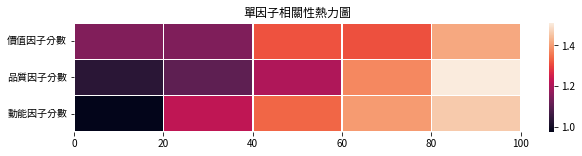

In [ ]:
fig, ax = plt.subplots(figsize=(10,2))       
ax = sns.heatmap(corrPolyDf,  linewidths=.5,ax=ax)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)
x_label = np.arange(0,101,20)
plt.xticks(range(len(x_label)),x_label)
plt.yticks(np.arange(0.5, len(corrPolyDf.index), step=1),corrPolyDf.index)
plt.figsize=(30, 9)
plt.title("單因子相關性熱力圖")
plt.show()

### 線性回歸圖

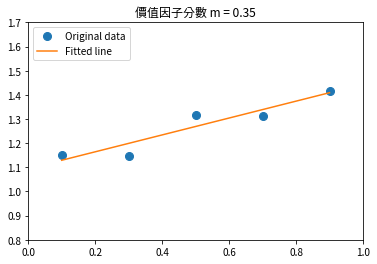

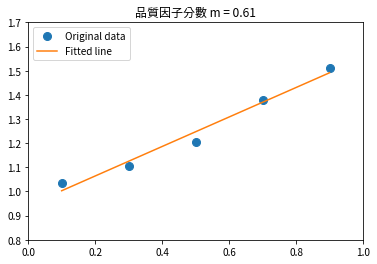

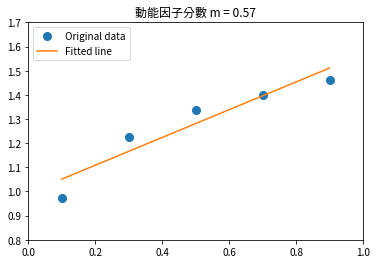

In [ ]:
slopePolyDf = pd.DataFrame()
x = np.arange(0.1,1,0.2)
for i in range(len(corrPolyDf.index)):
    y = corrPolyDf.iloc[i,:]
    m,c = findSlopeConst(x,y)
    slopePolyDf[corrPolyDf.index[i]] = [m]
    plotLine(x,y,m,c,corrPolyDf.index[i]+f' m = {round(m,2)}',[0, 1, 0.8, 1.7])
slopePolyDf.index=["相關性"]

### 相關性排名圖

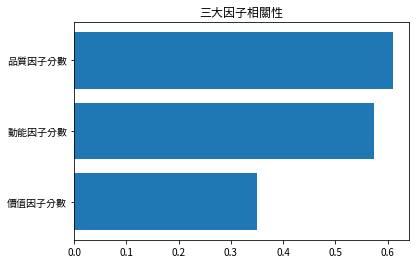

In [ ]:
slopePolyDf = slopePolyDf.T.sort_values("相關性")#預設column name為0
plt.barh(slopePolyDf.index,slopePolyDf["相關性"])
plt.yticks(np.arange(0,3),slopePolyDf.index)
plt.title("三大因子相關性")
plt.show()

## 細項單因子回測(相關性)

In [ ]:
# 按照百分位數切成5等分，回測每等分的報酬率

價值因子細項 = [營業現金流量對股價比,EBITDA對企業價值比,益本比,股東收益率]
品質因子細項 = [股東權益報酬率,收益變動率,現金流量對資產比,資產報酬率,毛利對資產比,槓桿度]
動能因子細項 = [股價動能,營利動能]
corrDf = pd.DataFrame()

for category in [價值因子細項,品質因子細項,動能因子細項]:
    for feature in category:
        corrList=[]
        categoryName = getVarName(category)
        featureName = getVarName(feature)
        feature = Z(feature)
        col = feature.columns.intersection(allTseColumns)
        feature = feature[col]
        # feature = Z(feature)
        for interval in range(0,100,20):
            scoreWeight = feature.applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
            cond = (scoreWeight >= scoreWeight.quantile_row(interval/100)) & (scoreWeight <= scoreWeight.quantile_row(interval/100+0.2))
            scoreWeight[~cond] = 0
            position = scoreWeight.index_str_to_date().loc[startDate:"2020-08-10"]
            report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
            report.benchmark = data.get('benchmark_return:發行量加權股價報酬指數').squeeze()
            corrList.append(report.creturn[-1])
        corrDf[categoryName+"-"+featureName] = corrList

corrDf.index = ["0-20","20-40","40-60","60-80","80-100"]
corrDf = corrDf.T
corrDf

,0-20,20-40,40-60,60-80,80-100
價值因子細項-營業現金流量對股價比,1.141862,1.263185,1.200043,1.339530,1.317728
價值因子細項-EBITDA對企業價值比,1.135008,1.176773,1.226656,1.337372,1.421402
價值因子細項-益本比,1.068268,1.094460,1.229803,1.401130,1.558748
價值因子細項-股東收益率,1.255987,1.136053,1.328624,1.320028,1.107294
品質因子細項-股東權益報酬率,1.052347,1.156150,1.308487,1.295990,1.391751
品質因子細項-收益變動率,1.152071,1.241469,1.281080,1.300907,1.283928
品質因子細項-現金流量對資產比,1.115317,1.231280,1.263306,1.185368,1.409851
品質因子細項-資產報酬率,1.038567,1.161786,1.315945,1.282949,1.336877
品質因子細項-毛利對資產比,1.131169,1.129478,1.244763,1.321655,1.389994
品質因子細項-槓桿度,1.217727,1.284655,1.166552,1.274899,1.274552


### 熱力圖

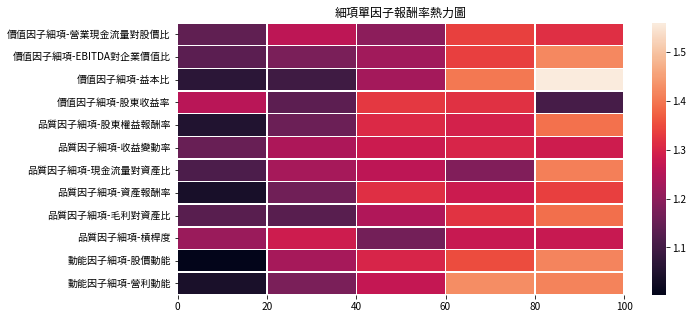

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(corrDf,  linewidths=.5,ax=ax)
ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)
x_label = np.arange(0,101,20)
plt.xticks(range(len(x_label)),x_label)
plt.yticks(np.arange(0.5, len(corrDf.index), step=1),corrDf.index)
plt.figsize=(30, 9)
plt.title("細項單因子報酬率熱力圖")
plt.show()

### 線性回歸圖

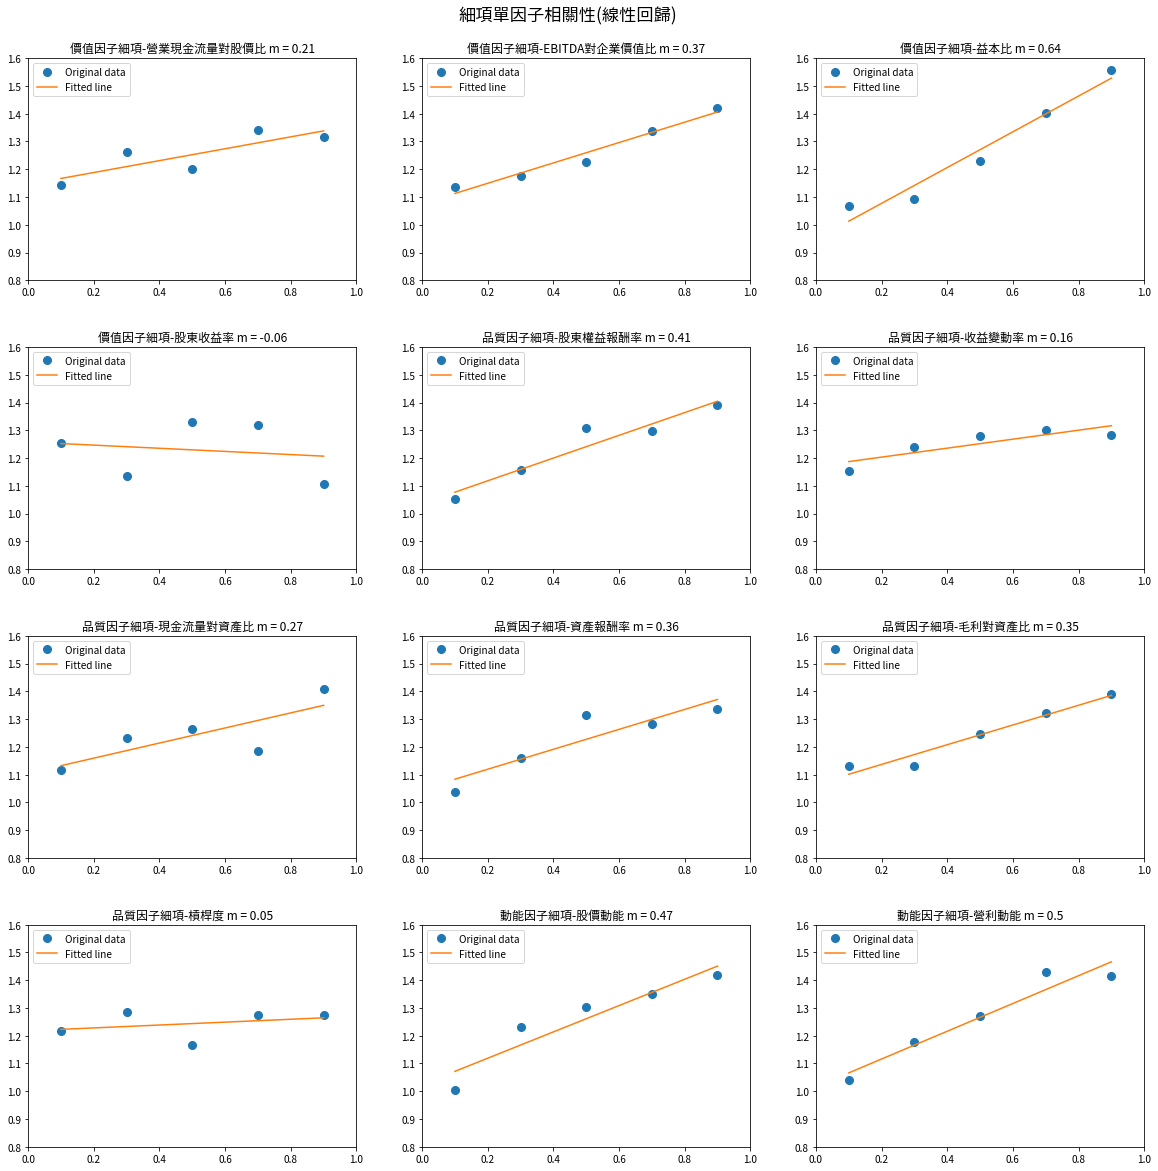

In [ ]:
slopeDf = pd.DataFrame()
fig, axs = plt.subplots(4,3)
fig.suptitle('細項單因子相關性(線性回歸)',fontsize='xx-large',fontweight='bold')
fig.set_figheight(18)
fig.set_figwidth(20)
x = np.arange(0.1,1,0.2)
for i in range(len(corrDf.index)):
    subplotI = i//3
    subplotJ = i%3
    y = corrDf.iloc[i,:]
    m,c = findSlopeConst(x,y)
    slopeDf[corrDf.index[i]] = [m]
    plotLine(x,y,m,c,corrDf.index[i]+f' m = {round(m,2)}',[0, 1, 0.8, 1.6],subplots = axs[subplotI,subplotJ])
slopeDf.index = ['相關性']
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.94, 
                    wspace=0.2, 
                    hspace=0.3)
plt.show()

### 相關性排名圖

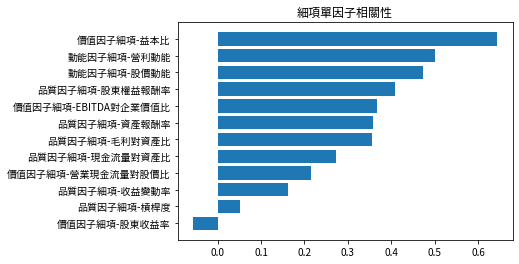

In [ ]:
slopeDf = slopeDf.T.sort_values("相關性")#預設column name為0
plt.barh(slopeDf.index,slopeDf["相關性"])
plt.yticks(np.arange(0,12),slopeDf.index)
plt.title("細項單因子相關性")
plt.show()

# 優化策略步驟
1. 測試不同市場(單純上櫃、上市+上櫃) => 結論：只取上市並沒有特別優點，推測是為考量流動性，因此之後取上櫃&上市
2. 篩選單因子(降低overfitting&雜訊的可能姓) => 取相關性最高三名&最低三名，重新計算權重，證明前三名和後三名的因子有其效度差異
3. 限縮持股數目(用測試集測試適合的持股數) => 結論：80%約到參數高原，考量到持有的股票數目，設定threshold為95%

未來方向 : 嘗試其他單因子組合、加入finlab過往因子(ex:PEG)

## 測試不同市場

### 訓練集表現 (training)

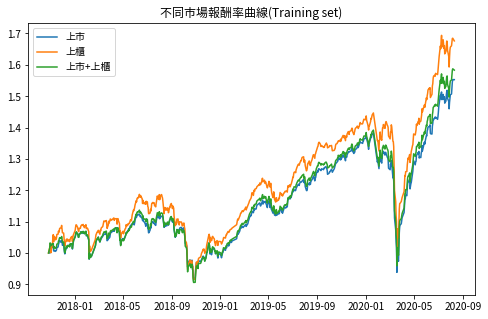

In [ ]:
# 上市 (training)
cond = 多因子權重係數_TSE < 多因子權重係數_TSE.quantile_row(0.75) #計算多因子權重係數小於75分位數的股票
多因子權重係數_TSE[cond] = 0 # 設權重為0
position = 多因子權重係數_TSE.index_str_to_date().loc[startDate:"2020-08-10"]
position.dropna(how="all",inplace=True)
report1 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 上櫃 (training)
col = 多因子權重係數.columns.intersection(allOtcColumns)
多因子權重係數_OTC = 多因子權重係數[col]
cond = 多因子權重係數_OTC < 多因子權重係數_OTC.quantile_row(0.75) #計算多因子權重係數小於75分位數的股票
多因子權重係數_OTC[cond] = 0 # 設權重為0
position = 多因子權重係數_OTC.index_str_to_date().loc[startDate:"2020-08-10"] 
position.dropna(how="all",inplace=True)
report2 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 上市+上櫃 (training)
多因子權重係數_TSEOTC = 多因子權重係數.copy()
col = 多因子權重係數_TSEOTC.columns.intersection(allColumns)
cond = 多因子權重係數_TSEOTC < 多因子權重係數_TSEOTC.quantile_row(0.75) #計算多因子權重係數小於75分位數的股票
多因子權重係數_TSEOTC[cond] = 0 # 設權重為0
position = 多因子權重係數_TSEOTC.index_str_to_date().loc[startDate:"2020-08-10"]
position.dropna(how="all",inplace=True)
report3 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 作圖
plt.figure(figsize=(8,5))
plt.plot(report1.creturn,label="上市")
plt.plot(report2.creturn,label="上櫃")
plt.plot(report3.creturn,label="上市+上櫃")
plt.title("不同市場報酬率曲線(Training set)")
plt.legend()
plt.show()

### 測試集表現 (testing)

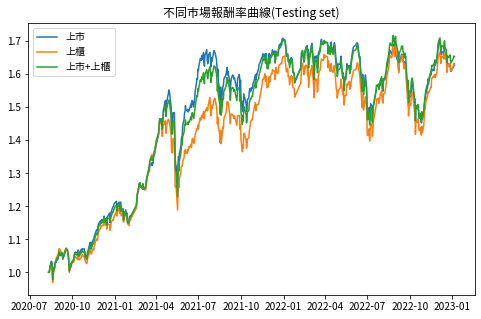

In [ ]:
# 單純上市(testing)
position = 多因子權重係數_TSE.index_str_to_date().loc["2020-08-10":] #指數從此時編纂
report4 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 上櫃 (testing)
position = 多因子權重係數_OTC.index_str_to_date().loc["2020-08-10":] #指數從此時編纂
report5 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 上市+上櫃 (testing)
position = 多因子權重係數_TSEOTC.index_str_to_date().loc["2020-08-10":] #指數從此時編纂
report6 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

plt.figure(figsize=(8,5))
plt.plot(report4.creturn,label="上市")
plt.plot(report5.creturn,label="上櫃")
plt.plot(report6.creturn,label="上市+上櫃")
plt.title("不同市場報酬率曲線(Testing set)")
plt.legend()
plt.show()

## 組合有效的單因子

### 訓練集表現 (training)

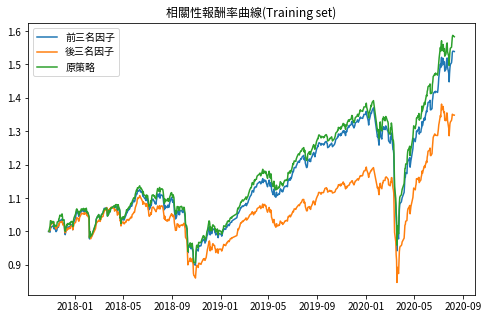

In [ ]:
# 相關性前三名(益本比、營利動能、股價動能)
scoreTop3 = (Z(益本比) + Z(營利動能) + Z(股價動能))/3
col = scoreTop3.columns.intersection(allColumns)
scoreTop3 = scoreTop3[col].applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
cond = scoreTop3 <= scoreTop3.quantile_row(0.75)
scoreTop3[cond] = 0
position = scoreTop3.index_str_to_date().loc[startDate:"2020-08-10"]
position.dropna(how="all",inplace=True)
report1 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 相關性後三名(收益變動率、槓桿度、股東收益率)
scoreLast3 = (Z(收益變動率)+Z(槓桿度)+Z(股東收益率))/3
col = scoreLast3.columns.intersection(allColumns)
scoreLast3 = scoreLast3[col].applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)
cond = scoreLast3 <= scoreLast3.quantile_row(0.75)
scoreLast3[cond] = 0
position = scoreLast3.index_str_to_date().loc[startDate:"2020-08-10"]
position.dropna(how="all",inplace=True)
report2 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# Benchmark (原策略)
col = 多因子權重係數.columns.intersection(allColumns)
scoreBenchmark = 多因子權重係數[col]
cond = scoreBenchmark < scoreBenchmark.quantile_row(0.75) #計算多因子權重係數小於75分位數的股票
scoreBenchmark[cond] = 0 # 設權重為0
position = scoreBenchmark.index_str_to_date().loc[startDate:"2020-08-10"]
report3 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 作圖
plt.figure(figsize=(8,5))
plt.plot(report1.creturn,label="前三名因子")
plt.plot(report2.creturn,label="後三名因子")
plt.plot(report3.creturn,label="原策略")
plt.title("相關性報酬率曲線(Training set)")
plt.legend()
plt.show()

### 測試集表現 (testing)

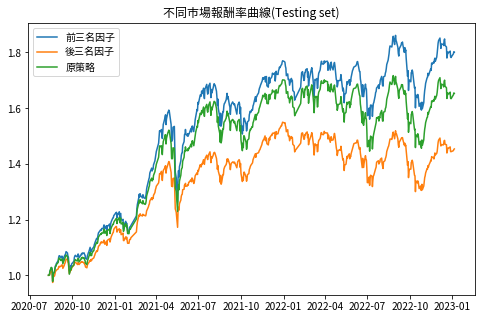

In [ ]:
# 相關性前三名(益本比、營利動能、股價動能)
position = scoreTop3.index_str_to_date().loc["2020-08-10":]
report4 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 相關性後三名(收益變動率、槓桿度、股東收益率)
position = scoreLast3.index_str_to_date().loc["2020-08-10":]
report5 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# Benchmark (原策略)
position = scoreBenchmark.index_str_to_date().loc["2020-08-10":]
report6 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 作圖
plt.figure(figsize=(8,5))
plt.plot(report4.creturn,label="前三名因子")
plt.plot(report5.creturn,label="後三名因子")
plt.plot(report6.creturn,label="原策略")
plt.title("不同市場報酬率曲線(Testing set)")
plt.legend()
plt.show()

## 限縮持股數目

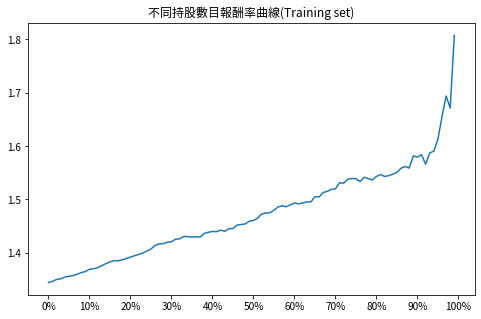

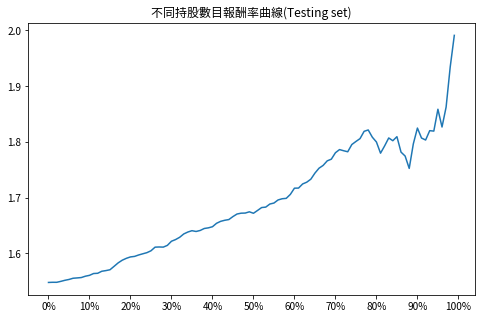

In [ ]:
# 最佳化持股百分位數 (限縮持股)

creturnTrainDf = pd.DataFrame()
creturnTestDf = pd.DataFrame()

score = (Z(益本比) + Z(營利動能) + Z(股價動能))/3
col = score.columns.intersection(allColumns)
score = score[col].applymap(lambda z: 1+z if(z>=0) else (1-z)**-1)


for i in range(0,100,1):
    cond = score > score.quantile_row(i/100)
    position = score[cond].index_str_to_date().loc[startDate:"2020-08-10"]
    position.dropna(how="all",inplace=True)
    report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
    creturnTrainDf[str(i)+"%"] = report.creturn

    position = score[cond].index_str_to_date().loc["2020-08-10":]
    position.dropna(how="all",inplace=True)
    report = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)
    creturnTestDf[str(i)+"%"] = report.creturn
    # print(i/100)

    
# 作圖
plt.figure(figsize=(8,5))
plt.title("不同持股數目報酬率曲線(Training set)")
plt.plot(creturnTrainDf.iloc[-1,:])
plt.xticks(["0%","10%","20%","30%","40%","50%", "60%", "70%", "80%","90%","100%"])
plt.show()

plt.figure(figsize=(8,5))
plt.title("不同持股數目報酬率曲線(Testing set)")
plt.plot(creturnTestDf.iloc[-1,:])
plt.xticks(["0%","10%","20%","30%","40%","50%", "60%", "70%", "80%","90%","100%"])
plt.show()

# 優化結果報酬率

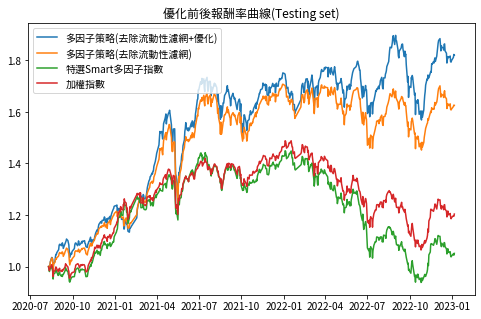

In [ ]:
# 最終結果
cond = score > score.quantile_row(93/100)
position = score[cond].index_str_to_date().loc["2020-08-10":]
position.dropna(how="all",inplace=True)
report1 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# 最初結果
position = 多因子權重係數_TSE.index_str_to_date().loc["2020-08-10":]
report2 = backtest.sim(position, resample=None,fee_ratio=0,tax_ratio=0,upload=False)

# Smart
index =  data.get('stock_index_price:收盤指數') 
smartIndex = index["上市特選Smart多因子指數"].dropna() / index["上市特選Smart多因子指數"].dropna()[0]

# 加權指數
TAIEX = data.get('benchmark_return:發行量加權股價報酬指數').loc["2020-08-10":] / data.get('benchmark_return:發行量加權股價報酬指數').loc["2020-08-10"][0]


# 作圖
plt.figure(figsize=(8,5))
plt.title("優化前後報酬率曲線(Testing set)")
plt.plot(report1.creturn,label="多因子策略(去除流動性濾網+優化)")
plt.plot(report2.creturn,label="多因子策略(去除流動性濾網)")
plt.plot(smartIndex,label="特選Smart多因子指數")
plt.plot(TAIEX,label="加權指數")
plt.legend(loc='upper left')
plt.show()